count    2541.000000
mean      131.271350
std       162.519792
min         5.000000
25%        16.000000
50%        69.000000
75%       174.000000
max       814.000000
Name: pmi, dtype: float64


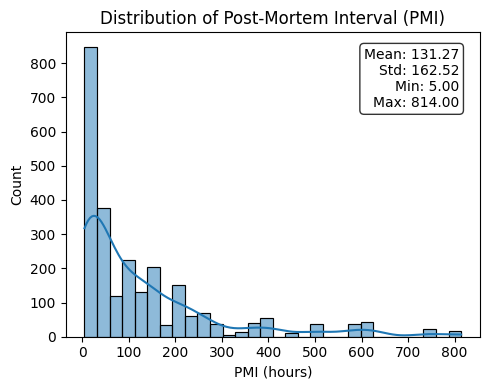

In [7]:
import pandas as pd 
import seaborn as sns
df = '/DATA2/akshay/Akshat/metadata/rgb_metadata.csv'
df = pd.read_csv(df)
print(df['pmi'].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.histplot(data=df, x='pmi', bins=30, kde=True)
plt.title('Distribution of Post-Mortem Interval (PMI)')
plt.xlabel('PMI (hours)')
plt.ylabel('Count')

# Add descriptive stats box
stats = df['pmi'].describe()
stats_text = f'Mean: {stats["mean"]:.2f}\n'
stats_text += f'Std: {stats["std"]:.2f}\n'
stats_text += f'Min: {stats["min"]:.2f}\n'
stats_text += f'Max: {stats["max"]:.2f}'

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


Device: cuda


Extracting DINO Features: 100%|██████████| 80/80 [03:57<00:00,  2.96s/it]


Iteration 1, loss = 21036.69645601
Validation score: -0.007022
Iteration 2, loss = 8301.52462964
Validation score: 0.308591
Iteration 3, loss = 4026.40188155
Validation score: 0.789209
Iteration 4, loss = 2590.04103396
Validation score: 0.808855
Iteration 5, loss = 1637.64197462
Validation score: 0.849407
Iteration 6, loss = 1195.37433544
Validation score: 0.861795
Iteration 7, loss = 957.15289658
Validation score: 0.869484
Iteration 8, loss = 781.62268480
Validation score: 0.882968
Iteration 9, loss = 653.91178920
Validation score: 0.889421
Iteration 10, loss = 551.39697226
Validation score: 0.905532
Iteration 11, loss = 470.90299044
Validation score: 0.909311
Iteration 12, loss = 386.37400342
Validation score: 0.918132
Iteration 13, loss = 329.14169440
Validation score: 0.918542
Iteration 14, loss = 290.41969210
Validation score: 0.927810
Iteration 15, loss = 229.24688020
Validation score: 0.931502
Iteration 16, loss = 189.67684408
Validation score: 0.934996
Iteration 17, loss = 158.

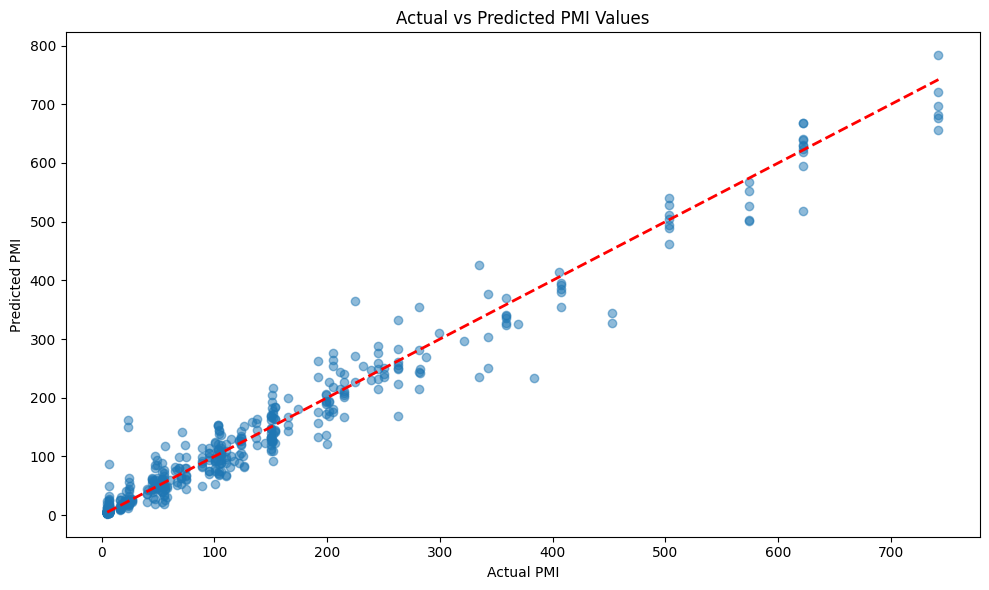

In [6]:
import torch
import timm
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt 
from sklearn.model_selection import learning_curve
import seaborn as sns


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# ✅ Correct way to load the DINO model
model = timm.create_model("vit_base_patch16_224_dino", pretrained=True)  # No unpacking needed
model.eval()
model.to(device)

# Function to extract DINO embeddings
def extract_dino_features(image_paths, batch_size=32):
    features = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting DINO Features"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_COLOR)  # Read as grayscale
            if img is None:
                print(f"Warning: Unable to load image {path}")
                batch_images.append(torch.zeros((3, 224, 224)))  # Dummy tensor for missing images
                continue
            
            img = cv2.resize(img, (224, 224))  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to grayscale
            img = torch.tensor(img).permute(2, 0, 1).float() / 255.0  # Normalize
            batch_images.append(img)

        batch_tensor = torch.stack(batch_images).to(device)  # Stack tensors
        with torch.no_grad():
            batch_features = model.forward_features(batch_tensor)  # ✅ Correct way to get embeddings
            batch_features = batch_features.cpu().numpy()  # Convert to numpy
        features.append(batch_features)

    return np.vstack(features)  # Combine all batches

# Load metadata
metadata_file = "/home/akshay/Akshat/metadata/rgb_metadata.csv"
metadata = pd.read_csv(metadata_file)

# Generate image file paths
image_paths = metadata['filename'].apply(lambda x: f"/home/akshay/Akshat/Warsaw-BioBase-Postmortem-Iris-v3/RGB_Cropped_ISO-Resolution/{x}").tolist()

# Extract DINO features
dino_features = extract_dino_features(image_paths)
# dino_features = dino_features.mean(axis=1)  # Average pooling
dino_features = dino_features[:, 0, :]  # CLS token

# Convert to DataFrame and add PMI values
feature_df = pd.DataFrame(dino_features)
feature_df['PMI'] = metadata['pmi']

scaler = StandardScaler()
X = scaler.fit_transform(feature_df.drop(columns=['PMI']))
y = feature_df['PMI']
# Split data
# X = feature_df.drop(columns=['PMI'])  # Features (DINO embeddings)
# y = feature_df['PMI']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Train and compare models
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# mae_scores = {model_name: mean_absolute_error(y_test, predictions[model_name]) for model_name in predictions.columns}
# mae_df = pd.DataFrame.from_dict(mae_scores, orient='index', columns=['MAE'])
# final_results = models.join(mae_df)

# Display results
# print(models)

mlp = MLPRegressor(
    hidden_layer_sizes=(512, 216, 128),
    activation='relu',
    solver='adam',
    max_iter=1000, 
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose = True,
    learning_rate='adaptive',
    learning_rate_init=0.001

)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PMI')
plt.ylabel('Predicted PMI')
plt.title('Actual vs Predicted PMI Values')
plt.tight_layout()
plt.show()


Device: cuda


Extracting DINO Features: 100%|██████████| 70/70 [03:30<00:00,  3.01s/it]


Iteration 1, loss = 15925.48649391
Validation score: -0.135291
Iteration 2, loss = 7084.98071114
Validation score: 0.671432
Iteration 3, loss = 3581.48343953
Validation score: 0.783360
Iteration 4, loss = 2724.48568913
Validation score: 0.822042
Iteration 5, loss = 2035.12734704
Validation score: 0.838638
Iteration 6, loss = 1745.52652383
Validation score: 0.855697
Iteration 7, loss = 1517.32992241
Validation score: 0.873505
Iteration 8, loss = 1297.99931312
Validation score: 0.879594
Iteration 9, loss = 1145.83781136
Validation score: 0.891713
Iteration 10, loss = 990.58353345
Validation score: 0.904036
Iteration 11, loss = 858.02680636
Validation score: 0.911386
Iteration 12, loss = 749.53628317
Validation score: 0.917007
Iteration 13, loss = 644.64923459
Validation score: 0.923087
Iteration 14, loss = 576.34365350
Validation score: 0.926455
Iteration 15, loss = 495.37320563
Validation score: 0.929329
Iteration 16, loss = 436.23417941
Validation score: 0.931144
Iteration 17, loss = 4

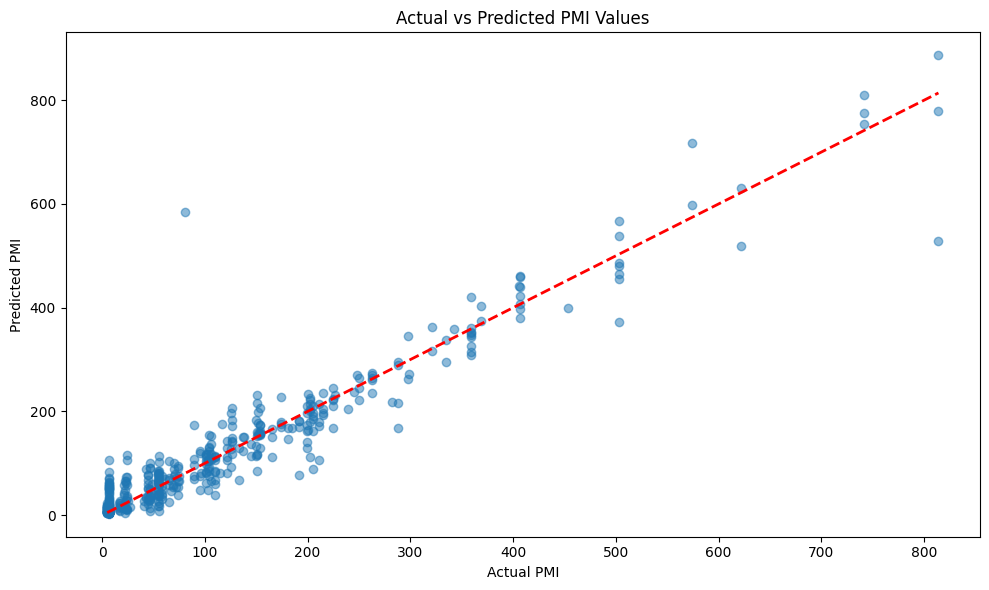

Iteration 1, loss = 254.37836673
Validation score: -0.720910
Iteration 1, loss = 16711.68862603
Validation score: -0.471097
Iteration 2, loss = 210.70817461
Validation score: -0.497847
Iteration 1, loss = 27497.93833293
Iteration 1, loss = 18630.91959204
Validation score: -0.255166
Validation score: -0.628831
Iteration 3, loss = 173.99206305
Validation score: -0.277305
Iteration 4, loss = 139.30640121
Validation score: -0.092293
Iteration 2, loss = 25705.18047323
Validation score: -0.104520
Iteration 5, loss = 113.35136846
Validation score: 0.006410
Iteration 1, loss = 14005.49460143
Iteration 1, loss = 14843.51047807
Validation score: -0.589780Validation score: -0.210901

Iteration 6, loss = 104.84950342
Validation score: 0.048482
Iteration 2, loss = 15950.29324333
Validation score: -0.171115
Iteration 3, loss = 22221.75538942
Validation score: 0.170274Iteration 1, loss = 18432.42726321Iteration 7, loss = 104.50852596

Iteration 1, loss = 56198.28385806
Validation score: 0.126810
Vali

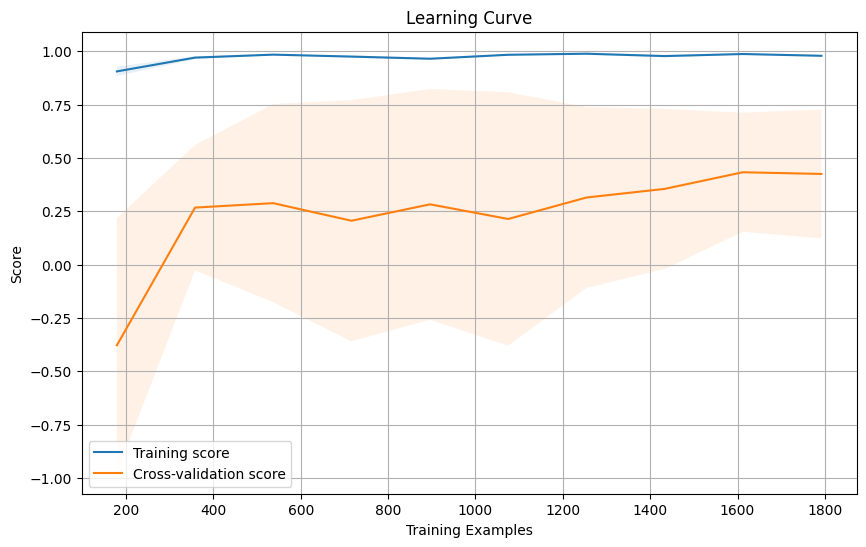

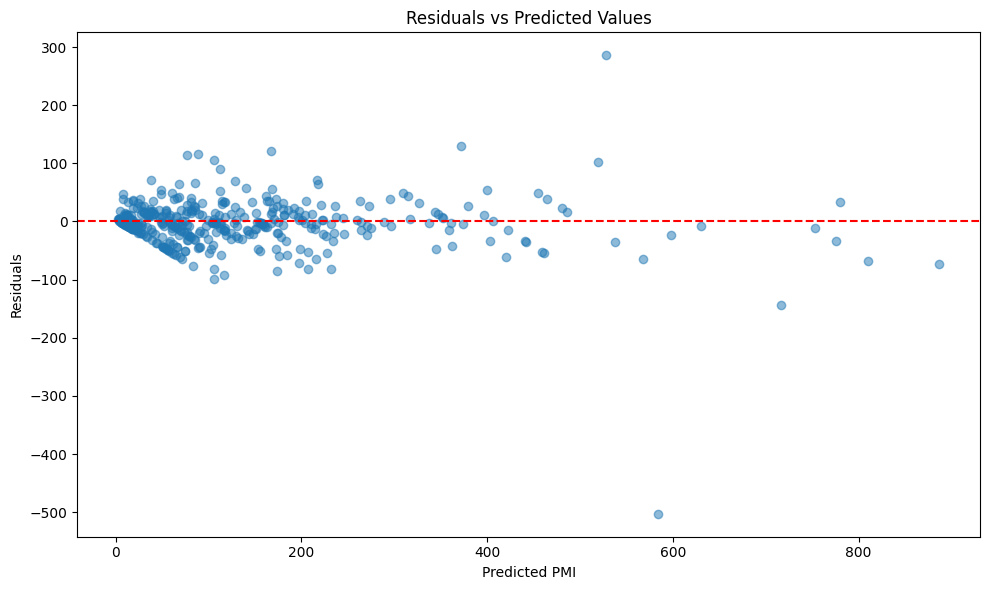

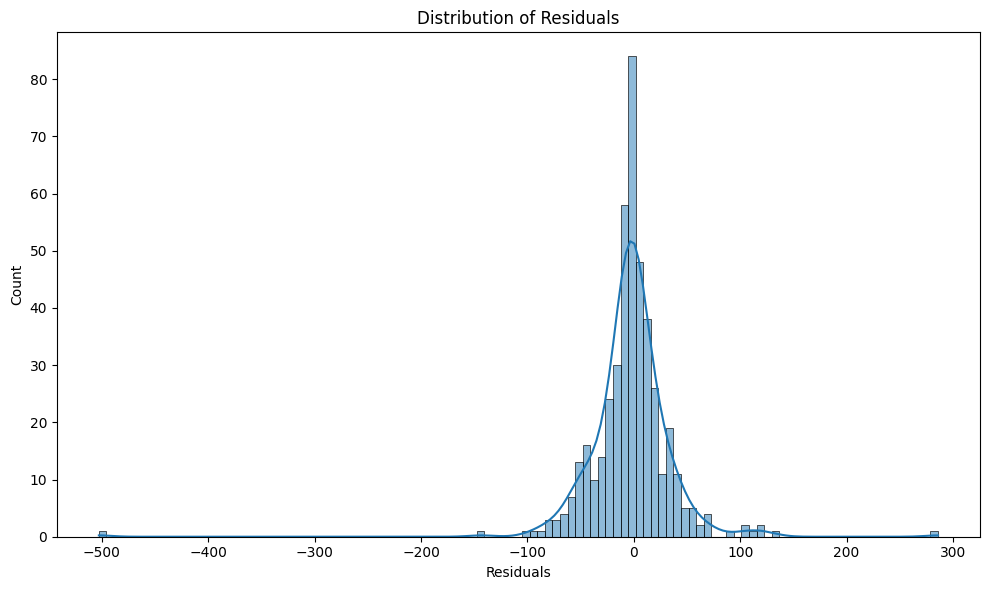

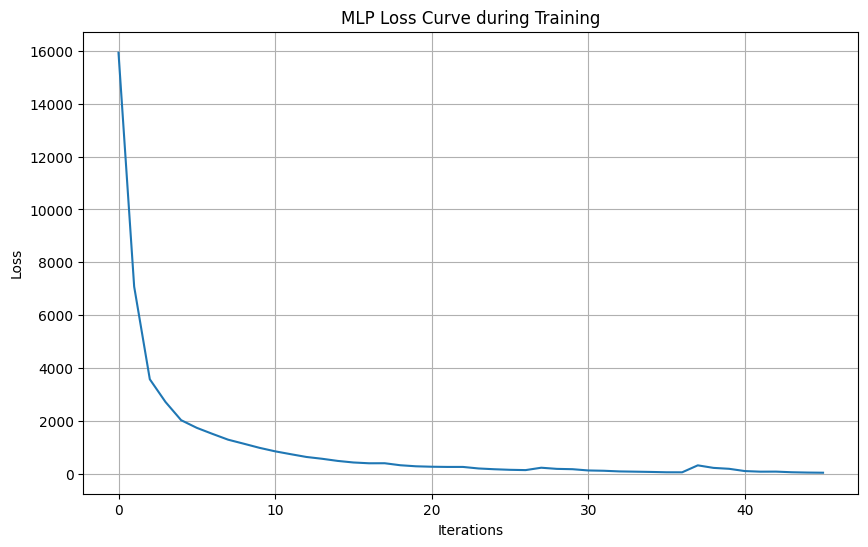

In [5]:
import torch
import timm
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt 
from sklearn.model_selection import learning_curve
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# ✅ Correct way to load the DINO model
model = timm.create_model("vit_base_patch16_224_dino", pretrained=True)  # No unpacking needed
model.eval()
model.to(device)

# Function to extract DINO embeddings
def extract_dino_features(image_paths, batch_size=32):
    features = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting DINO Features"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if img is None:
                print(f"Warning: Unable to load image {path}")
                batch_images.append(torch.zeros((3, 224, 224)))  # Dummy tensor for missing images
                continue
            
            img = cv2.resize(img, (224, 224))  # Resize
            img = np.stack([img, img, img], axis=-1)  # Convert to 3-channel grayscale
            img = torch.tensor(img).permute(2, 0, 1).float() / 255.0  # Normalize
            batch_images.append(img)

        batch_tensor = torch.stack(batch_images).to(device)  # Stack tensors
        with torch.no_grad():
            batch_features = model.forward_features(batch_tensor)  # ✅ Correct way to get embeddings
            batch_features = batch_features.cpu().numpy()  # Convert to numpy
        features.append(batch_features)

    return np.vstack(features)  # Combine all batches

# Load metadata
metadata_file = "/home/akshay/Akshat/metadata/nir_metadata.csv"
metadata = pd.read_csv(metadata_file)

# Generate image file paths
image_paths = metadata['filename'].apply(lambda x: f"/home/akshay/Akshat/Warsaw-BioBase-Postmortem-Iris-v3/NIR_ISO-Resolution/{x}").tolist()

# Extract DINO features
dino_features = extract_dino_features(image_paths)
# dino_features = dino_features.mean(axis=1)  # Average pooling
dino_features = dino_features[:, 0, :]  # CLS token

# Convert to DataFrame and add PMI values
feature_df = pd.DataFrame(dino_features)
feature_df['PMI'] = metadata['pmi']

scaler = StandardScaler()
X = scaler.fit_transform(feature_df.drop(columns=['PMI']))
y = feature_df['PMI']
# Split data
# X = feature_df.drop(columns=['PMI'])  # Features (DINO embeddings)
# y = feature_df['PMI']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Train and compare models
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# mae_scores = {model_name: mean_absolute_error(y_test, predictions[model_name]) for model_name in predictions.columns}
# mae_df = pd.DataFrame.from_dict(mae_scores, orient='index', columns=['MAE'])
# final_results = models.join(mae_df)

# Display results
# print(models)

mlp = MLPRegressor(
    hidden_layer_sizes=(512, 216, 128),
    activation='relu',
    solver='adam',
    max_iter=1000, 
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose = True,
    learning_rate='adaptive',
    learning_rate_init=0.001

)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PMI')
plt.ylabel('Predicted PMI')
plt.title('Actual vs Predicted PMI Values')
plt.tight_layout()
plt.show()


def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Call the function after model training
plot_learning_curve(mlp, X, y)

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted PMI')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Add a histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('MLP Loss Curve during Training')
plt.grid(True)
plt.show()

Device: cuda


Extracting CLIP Features: 100%|██████████| 70/70 [00:38<00:00,  1.82it/s]


Iteration 1, loss = 15812.27701461
Validation score: -0.006837
Iteration 2, loss = 8152.59070729
Validation score: 0.373898
Iteration 3, loss = 5317.52406144
Validation score: 0.556533
Iteration 4, loss = 4037.01305406
Validation score: 0.624311
Iteration 5, loss = 3492.66058793
Validation score: 0.661647
Iteration 6, loss = 3084.89511880
Validation score: 0.698370
Iteration 7, loss = 2675.07373747
Validation score: 0.726133
Iteration 8, loss = 2405.87942601
Validation score: 0.729650
Iteration 9, loss = 2330.26892699
Validation score: 0.736988
Iteration 10, loss = 2061.15664213
Validation score: 0.751988
Iteration 11, loss = 1853.99394073
Validation score: 0.765535
Iteration 12, loss = 1815.95383373
Validation score: 0.767665
Iteration 13, loss = 1582.63055986
Validation score: 0.779840
Iteration 14, loss = 1407.27096603
Validation score: 0.787876
Iteration 15, loss = 1308.11176176
Validation score: 0.788804
Iteration 16, loss = 1147.92212120
Validation score: 0.776018
Iteration 17, l

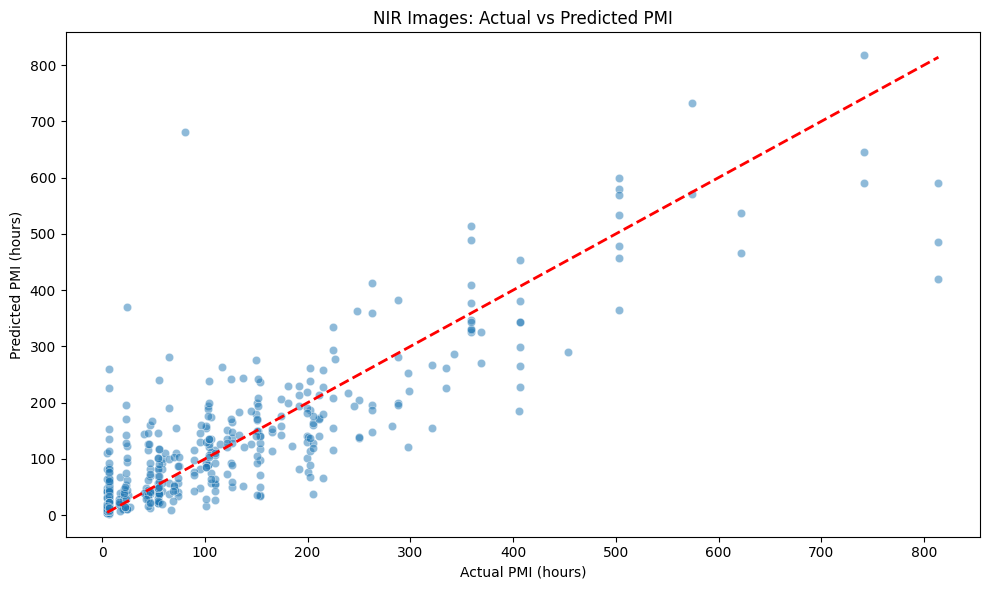

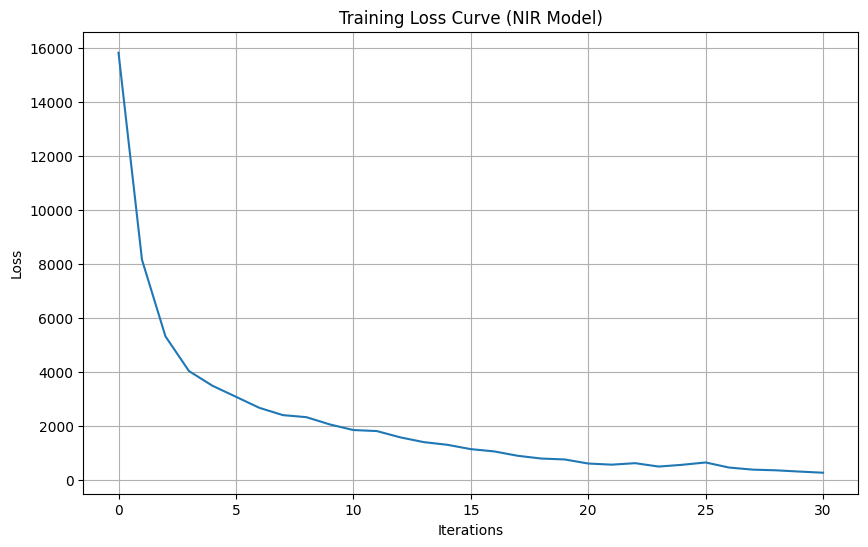

In [7]:
import torch
import timm
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_clip_features(image_paths, batch_size=32):
    features = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting CLIP Features"):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []

        for path in batch_paths:
            try:
                # Read NIR image as grayscale
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    raise Exception("Failed to load image")
                
                # Convert to RGB by repeating the grayscale channel
                img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                img_pil = Image.fromarray(img_rgb)
                batch_images.append(img_pil)
            except Exception as e:
                print(f"Warning: Unable to load image {path}: {str(e)}")
                batch_images.append(Image.new("RGB", (224, 224), color='black'))
            
        inputs = processor.image_processor(batch_images, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            vision_outputs = model.vision_model(**inputs)
            batch_features = vision_outputs.pooler_output.cpu().numpy()
        features.append(batch_features)

    return np.vstack(features)

# Load NIR metadata
metadata_file = "/home/akshay/Akshat/metadata/nir_metadata.csv"
metadata = pd.read_csv(metadata_file)

# Generate NIR image file paths
image_paths = metadata['filename'].apply(
    lambda x: f"/home/akshay/Akshat/Warsaw-BioBase-Postmortem-Iris-v3/NIR_ISO-Resolution/{x}"
).tolist()

# Extract features
clip_features = extract_clip_features(image_paths)

# Prepare data
feature_df = pd.DataFrame(clip_features)
feature_df['PMI'] = metadata['pmi']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(feature_df.drop(columns=['PMI']))
y = feature_df['PMI']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),
    activation='relu',
    solver='adam',
    max_iter=1000, 
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    learning_rate='adaptive',
    learning_rate_init=0.001
)

mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
print("\nModel Performance on NIR Images:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PMI (hours)')
plt.ylabel('Predicted PMI (hours)')
plt.title('NIR Images: Actual vs Predicted PMI')
plt.tight_layout()
plt.show()

# Loss curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve (NIR Model)')
plt.grid(True)
plt.show()

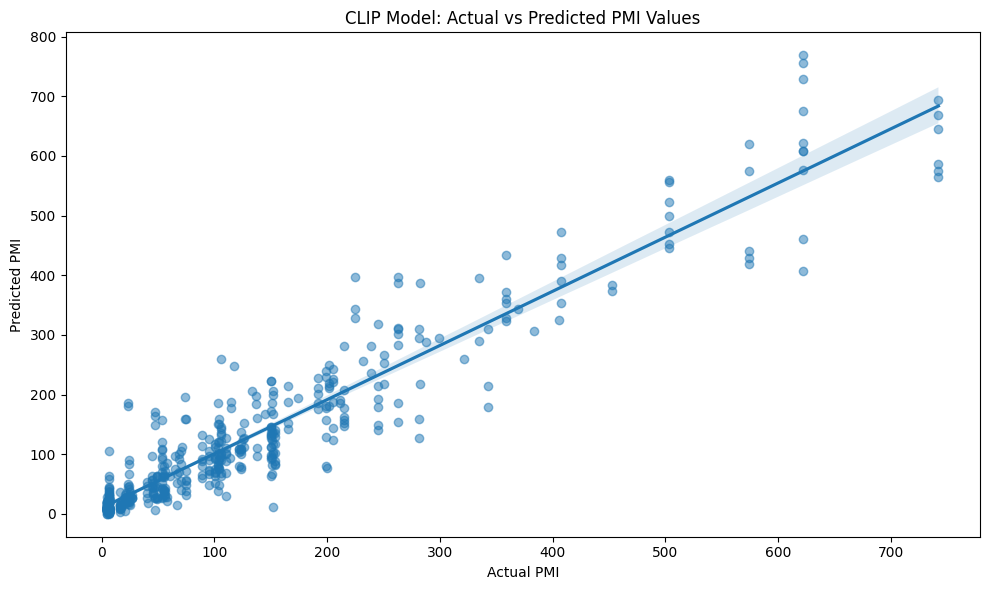

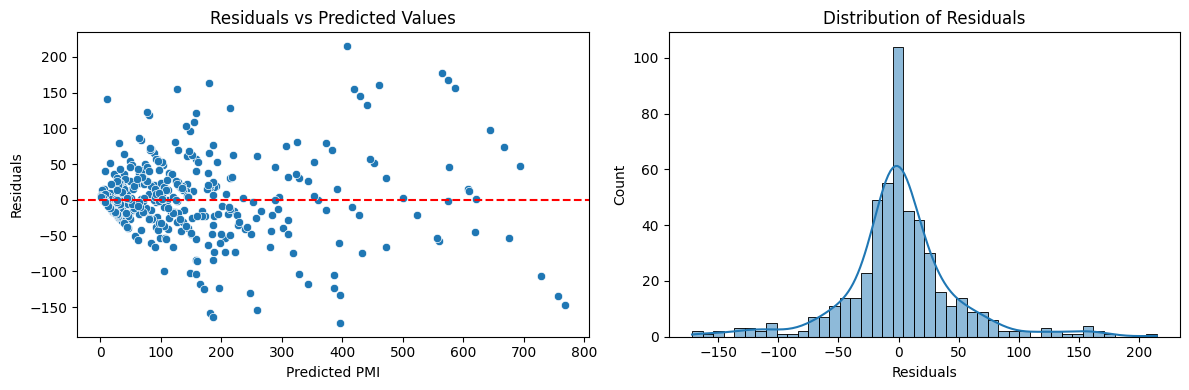

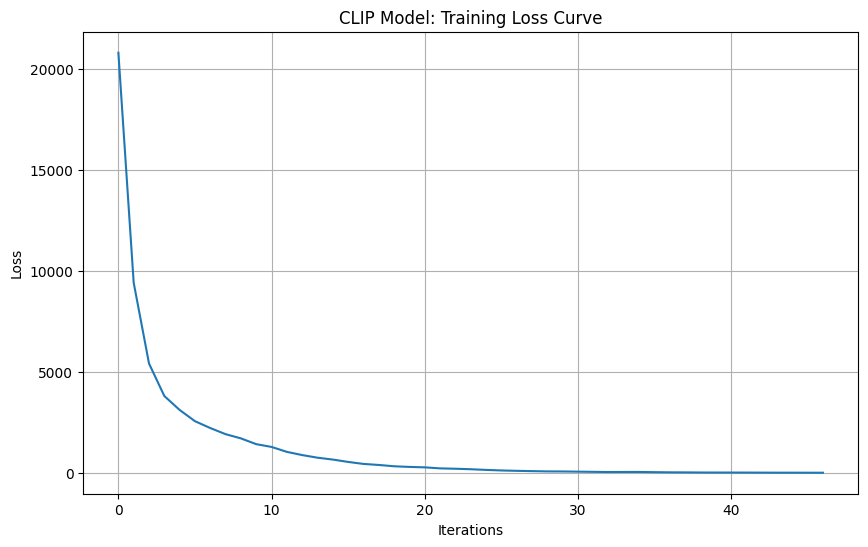

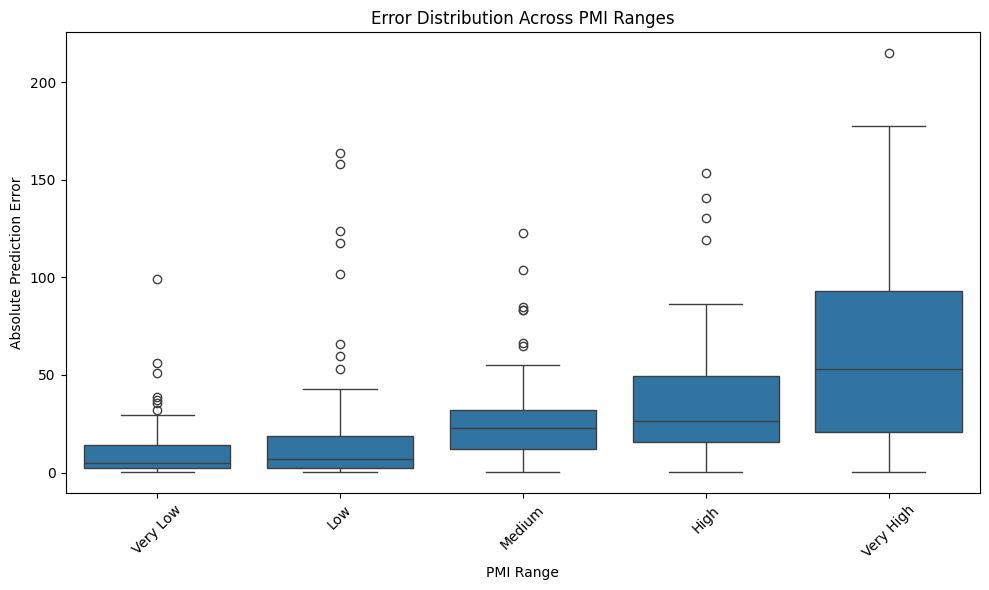

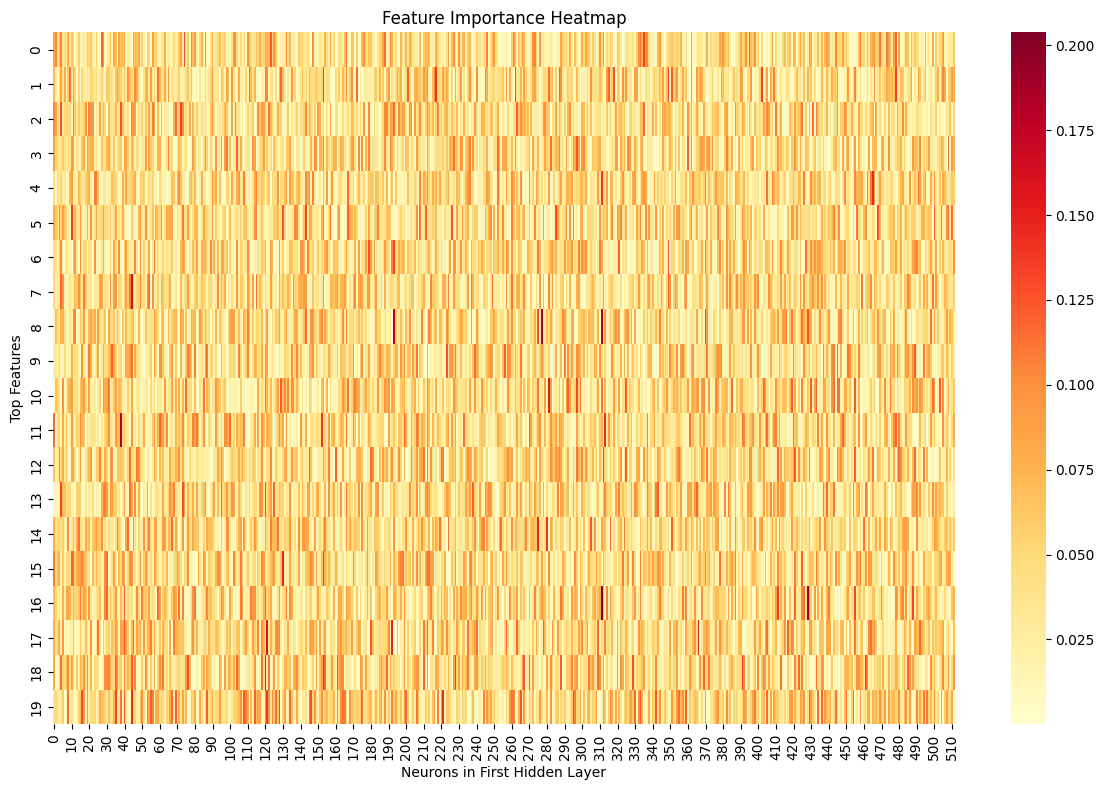

In [5]:
# 1. Actual vs Predicted Plot with regression line
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5})
plt.xlabel('Actual PMI')
plt.ylabel('Predicted PMI')
plt.title('CLIP Model: Actual vs Predicted PMI Values')
plt.tight_layout()
plt.show()

# 2. Learning Curves
# def plot_learning_curves(estimator, X, y):
#     train_sizes, train_scores, val_scores = learning_curve(
#         estimator, X, y, cv=5, 
#         train_sizes=np.linspace(0.1, 1.0, 10),
#         scoring='neg_mean_squared_error'
#     )
    
#     train_scores_mean = -np.mean(train_scores, axis=1)
#     val_scores_mean = -np.mean(val_scores, axis=1)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(train_sizes, train_scores_mean, label='Training error')
#     plt.plot(train_sizes, val_scores_mean, label='Validation error')
#     plt.xlabel('Training Set Size')
#     plt.ylabel('Mean Squared Error')
#     plt.title('CLIP Model: Learning Curves')
#     plt.legend(loc='best')
#     plt.grid(True)
#     plt.show()

# plot_learning_curves(mlp, X, y)

# 3. Residuals Analysis
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted PMI')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.subplot(122)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

# 4. Training Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('CLIP Model: Training Loss Curve')
plt.grid(True)
plt.show()

# 5. Error Analysis by PMI Ranges
error_df = pd.DataFrame({
    'Actual_PMI': y_test,
    'Absolute_Error': np.abs(y_test - y_pred)
})
error_df['PMI_Range'] = pd.qcut(error_df['Actual_PMI'], q=5, 
                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='PMI_Range', y='Absolute_Error', data=error_df)
plt.xticks(rotation=45)
plt.xlabel('PMI Range')
plt.ylabel('Absolute Prediction Error')
plt.title('Error Distribution Across PMI Ranges')
plt.tight_layout()
plt.show()

# 6. Feature Importance Heatmap
def plot_feature_importance_heatmap(mlp, n_features=20):
    # Get absolute weights from first layer
    importance = np.abs(mlp.coefs_[0])
    mean_importance = np.mean(importance, axis=1)
    top_indices = np.argsort(mean_importance)[-n_features:]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(importance[top_indices], cmap='YlOrRd')
    plt.xlabel('Neurons in First Hidden Layer')
    plt.ylabel('Top Features')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(mlp)

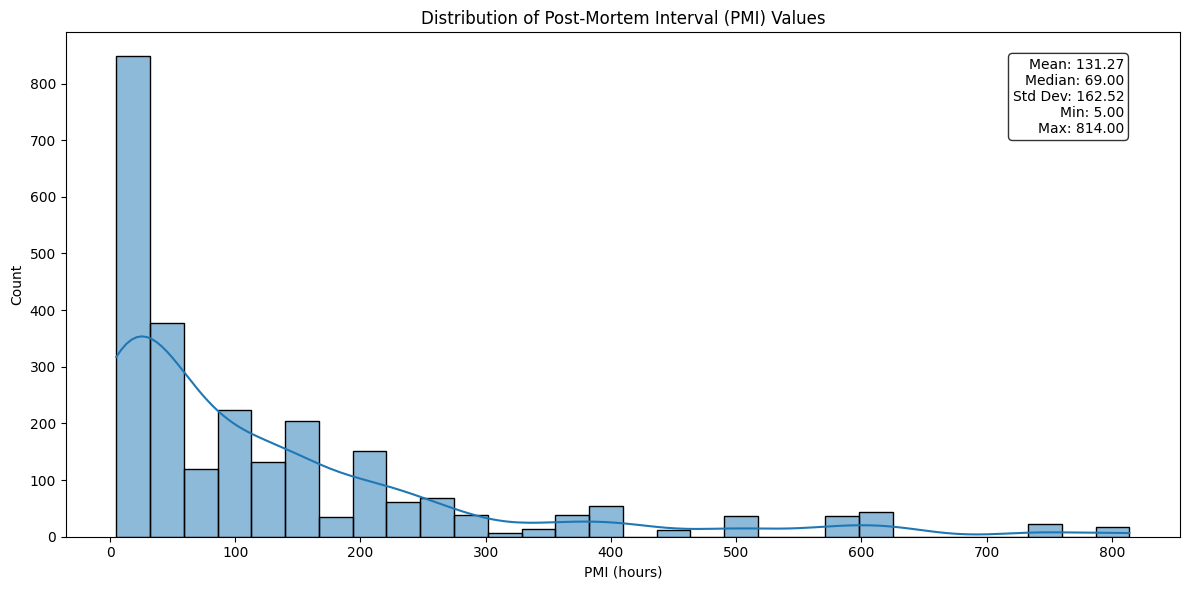


Unique PMI values:
[5.0, 7.0, 16.0, 17.0, 20.5, 21.0, 22.0, 23.0, 24.0, 25.0, 27.0, 40.0, 41.0, 43.0, 45.0, 46.0, 47.0, 49.0, 54.0, 55.0, 56.0, 58.0, 61.0, 65.0, 67.0, 69.0, 70.0, 71.0, 72.0, 74.0, 75.0, 89.0, 95.0, 96.0, 101.0, 103.0, 104.0, 106.0, 110.0, 114.0, 115.0, 117.0, 122.0, 124.0, 125.0, 126.0, 133.0, 137.0, 138.0, 145.0, 150.0, 151.0, 152.0, 154.0, 165.0, 174.0, 181.0, 185.0, 192.0, 199.0, 200.0, 202.0, 205.0, 211.0, 215.0, 225.0, 227.0, 232.0, 234.0, 239.0, 245.0, 248.0, 250.0, 263.0, 273.0, 281.0, 282.0, 288.0, 298.0, 299.0, 321.0, 335.0, 343.0, 359.0, 369.0, 383.0, 406.0, 407.0, 453.0, 455.0, 503.0, 574.0, 622.0, 742.0, 814.0]


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
metadata = pd.read_csv("/home/akshay/Akshat/metadata/rgb_metadata.csv")

# Create a figure with larger size
plt.figure(figsize=(12, 6))

# Create distribution plot
sns.histplot(data=metadata, x='pmi', bins=30, kde=True)

# Customize the plot
plt.title('Distribution of Post-Mortem Interval (PMI) Values', fontsize=12)
plt.xlabel('PMI (hours)', fontsize=10)
plt.ylabel('Count', fontsize=10)

# Add descriptive statistics as text
stats_text = f'Mean: {metadata.pmi.mean():.2f}\n'
stats_text += f'Median: {metadata.pmi.median():.2f}\n'
stats_text += f'Std Dev: {metadata.pmi.std():.2f}\n'
stats_text += f'Min: {metadata.pmi.min():.2f}\n'
stats_text += f'Max: {metadata.pmi.max():.2f}'

plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print unique PMI values
print("\nUnique PMI values:")
print(sorted(metadata.pmi.unique()))